In [32]:
#importing the required packages
import os
import matplotlib.pyplot as plt
import numpy as np
from keras import backend
import argparse
import random
import cv2
import glob

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [34]:
dataset_path = "Data\\gender_dataset_face_pretained"

In [35]:
# initial parameters
epochs = 100
lr_rate = 1e-3
batch_size = 64
img_dims = (96,96,3)
drop_out = 0.15

data = []
labels = []

In [36]:
# load image files from the dataset
random.seed(42)
image_files = [f for f in glob.glob(dataset_path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [37]:
# create groud-truth label from the image path
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label])

In [38]:
len(data)

2307

In [39]:
len(labels)

2307

In [40]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [41]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, 
                         width_shift_range=0.1,
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [42]:
print("training x length: ", len(trainX))
print("testing x length: ", len(testY))

training x length:  1845
testing x length:  462


## CNN

In [43]:
#Creating a function for saving the model at each epoch end
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_id = 0
        self.losses = ''
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses += "Epoch {}: accuracy -> {:.3f}, val_accuracy -> {:.3f}\n"\
            .format(str(self.epoch_id), logs.get('acc'), logs.get('val_acc'))
        self.epoch_id += 1
 
    def on_train_begin(self, logs={}):
        self.losses += 'Training begins...\n'

In [44]:
#Creating a checkpointer 
checkpointer = ModelCheckpoint(filepath = os.path.join('Detection\\Models', 'male_or_female_pretained.h5'), 
                               verbose=1,save_best_only=True)

In [45]:
# Initialising the CNN
model = Sequential()

In [46]:
model.add(Conv2D(32, (3,3), padding="same", input_shape=(img_dims)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(drop_out))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(drop_out))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(drop_out))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation("sigmoid"))

In [47]:
#compiling
optimizer = Adam(lr=lr_rate, decay= lr_rate/epochs)
metrics=['accuracy']
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

In [48]:
# Create a loss history
history = LossHistory()

In [49]:
# train the model
x = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, 
                        verbose=1, 
                        workers = 6, 
                        callbacks = [history, checkpointer], 
                        max_q_size = 100)

C:\Users\NiranjanKumar\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., verbose=1, max_queue_size=100, validation_data=(array([[[..., workers=6, steps_per_epoch=28, epochs=100)`
  if __name__ == '__main__':


Epoch 1/100
28/28 [==============================] - 6s 197ms/step - loss: 0.6729 - acc: 0.7490 - val_loss: 0.6742 - val_acc: 0.8214

Epoch 00001: val_loss improved from inf to 0.67424, saving model to Detection\Models\male_or_female_pretained.h5
Epoch 2/100
28/28 [==============================] - 3s 110ms/step - loss: 0.4399 - acc: 0.8215 - val_loss: 0.5327 - val_acc: 0.8193

Epoch 00002: val_loss improved from 0.67424 to 0.53266, saving model to Detection\Models\male_or_female_pretained.h5
Epoch 3/100
28/28 [==============================] - 3s 107ms/step - loss: 0.4266 - acc: 0.8343 - val_loss: 0.3993 - val_acc: 0.8582

Epoch 00003: val_loss improved from 0.53266 to 0.39930, saving model to Detection\Models\male_or_female_pretained.h5
Epoch 4/100
28/28 [==============================] - 3s 106ms/step - loss: 0.3398 - acc: 0.8611 - val_loss: 0.4275 - val_acc: 0.8561

Epoch 00004: val_loss did not improve from 0.39930
Epoch 5/100
28/28 [==============================] - 3s 109ms/step

28/28 [==============================] - 3s 108ms/step - loss: 0.1067 - acc: 0.9582 - val_loss: 0.2371 - val_acc: 0.9351

Epoch 00042: val_loss did not improve from 0.10115
Epoch 43/100
28/28 [==============================] - 3s 110ms/step - loss: 0.0761 - acc: 0.9712 - val_loss: 0.1933 - val_acc: 0.9383

Epoch 00043: val_loss did not improve from 0.10115
Epoch 44/100
28/28 [==============================] - 3s 109ms/step - loss: 0.0698 - acc: 0.9763 - val_loss: 0.1043 - val_acc: 0.9600

Epoch 00044: val_loss did not improve from 0.10115
Epoch 45/100
28/28 [==============================] - 3s 111ms/step - loss: 0.0589 - acc: 0.9752 - val_loss: 0.0826 - val_acc: 0.9675

Epoch 00045: val_loss improved from 0.10115 to 0.08262, saving model to Detection\Models\male_or_female_pretained.h5
Epoch 46/100
28/28 [==============================] - 3s 110ms/step - loss: 0.0665 - acc: 0.9780 - val_loss: 0.0544 - val_acc: 0.9859

Epoch 00046: val_loss improved from 0.08262 to 0.05438, saving model


Epoch 00084: val_loss did not improve from 0.05276
Epoch 85/100
28/28 [==============================] - 3s 114ms/step - loss: 0.0424 - acc: 0.9852 - val_loss: 0.0766 - val_acc: 0.9708

Epoch 00085: val_loss did not improve from 0.05276
Epoch 86/100
28/28 [==============================] - 3s 112ms/step - loss: 0.0501 - acc: 0.9800 - val_loss: 0.6693 - val_acc: 0.8236

Epoch 00086: val_loss did not improve from 0.05276
Epoch 87/100
28/28 [==============================] - 3s 104ms/step - loss: 0.0674 - acc: 0.9723 - val_loss: 0.1125 - val_acc: 0.9665

Epoch 00087: val_loss did not improve from 0.05276
Epoch 88/100
28/28 [==============================] - 3s 103ms/step - loss: 0.0595 - acc: 0.9790 - val_loss: 0.1396 - val_acc: 0.9654

Epoch 00088: val_loss did not improve from 0.05276
Epoch 89/100
28/28 [==============================] - 3s 111ms/step - loss: 0.0421 - acc: 0.9840 - val_loss: 0.1906 - val_acc: 0.9459

Epoch 00089: val_loss did not improve from 0.05276
Epoch 90/100
28/28

In [50]:
x.history.keys()

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])

In [51]:
plt.rcParams['figure.figsize'] = (15, 20)
plt.style.use("seaborn")

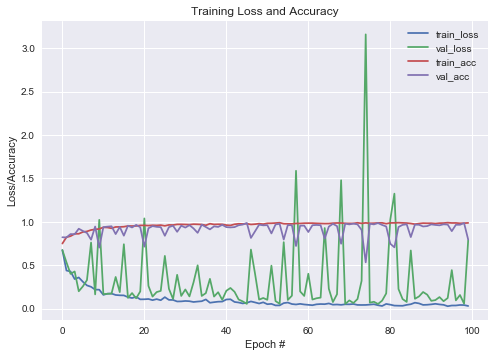

In [52]:
# plot training/validation loss/accuracy
N = epochs
plt.plot(np.arange(0,N), x.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), x.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), x.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), x.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

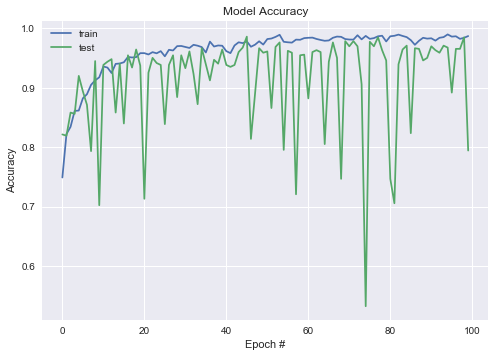

In [53]:
# summarize history for accuracy
plt.plot(x.history['acc'])
plt.plot(x.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

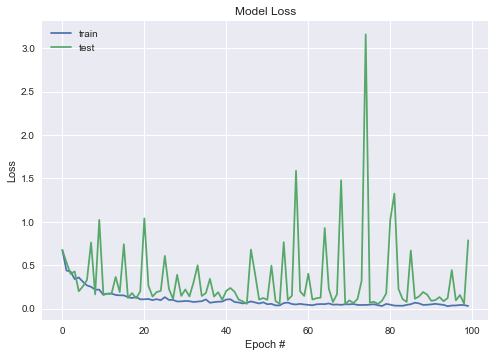

In [54]:
# summarize history for loss
plt.plot(x.history['loss'])
plt.plot(x.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
model_backup_path

'Detection\\Models\\male_or_female_pretained.h5'

In [56]:
score = model.evaluate(testX, testY)
print("Accuracy on test data:", score[1])

462/462 [==============================] - 0s 695us/step
Accuracy on test data: 0.7943722943722944


In [57]:
# Save loss history to file
loss_history_path = os.path.join('Detection\\Models', 'loss_history_pretained.log')
myFile = open(loss_history_path, 'w+')
myFile.write(history.losses)
myFile.close()

In [58]:
backend.clear_session()